
# 기초

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from scipy.integrate import simpson
from PIL import Image

# DSP
def square_wave(x, start, end):
    return np.where((x >= start) & (x < end), 1, 0)

def ctft(x, signal, freq_range):
    ft = []
    for freq in freq_range:
        integrand = signal * np.exp(-1j * 2 * np.pi * freq * x)
        ft_value = simpson(integrand, x=x)
        ft.append(ft_value)
    return np.array(ft)

def find_magnitude_phase(img):
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = np.abs(dft_shift)
    phase_spectrum = np.angle(dft_shift)
    return magnitude_spectrum, phase_spectrum

def create_ideal_lowpass_mask(shape, cutoff):
    mask = np.zeros(shape, np.uint8)
    for u in range(shape[0]):
        for v in range(shape[1]):
            D = np.sqrt((u - shape[0]//2)**2 + (v - shape[1]//2)**2)
            if D <= cutoff:
                mask[u, v] = 1
    return mask

def create_butterworth_lowpass_mask(shape, cutoff, order=2):
    mask = np.zeros(shape, np.float32)
    for u in range(shape[0]):
        for v in range(shape[1]):
            D = np.sqrt((u - shape[0]//2)**2 + (v - shape[1]//2)**2)
            mask[u, v] = 1 / (1 + (D / cutoff)**(2*order))
    return mask

# Image Processing
def extract_patch(img, x, y, width, height):
    patch = img[y:y+height, x:x+width]
    return patch

def apply_dft_filter(img, filter):
    assert img.shape == filter.shape

    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    filtered_dft = dft_shift * filter
    idft_shift = np.fft.ifftshift(filtered_dft)
    filtered_img = np.fft.ifft2(idft_shift)
    return np.abs(filtered_img)

def apply_conv_filter(img, kernel):
    result = np.zeros(img.shape, dtype=np.float32)
    padded_img = np.pad(img, ((kernel.shape[0]//2,kernel.shape[0]//2), (kernel.shape[1]//2,kernel.shape[1]//2)), mode='constant', constant_values=0)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded_img[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i,j] = np.sum(region * kernel)
    return result

# TODO: Make & Use this function
def apply_mul_filter(img, kernel):
    result = np.zeros(img.shape, dtype=np.float32)
    padded_img = np.pad(img, ((kernel.shape[0]//2,kernel.shape[0]//2), (kernel.shape[1]//2,kernel.shape[1]//2)), mode='constant', constant_values=0)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded_img[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i,j] = np.sum(region * kernel)
    return result

### Histogram
def calculate_histogram(img):
    histogram = np.zeros(256)
    for pixel in img.flatten():
        histogram[pixel] += 1
    return histogram

def cumulative_distribution(histogram):
    cdf = np.zeros_like(histogram)
    cdf[0] = histogram[0]
    for i in range(1, len(histogram)):
        cdf[i] = cdf[i-1] + histogram[i]
    return cdf

def histogram_equalization(img):
    hist = calculate_histogram(img)
    cdf = cumulative_distribution(hist)
    cdf_normalized = [(pixel - np.min(cdf)) / (np.max(cdf) - np.min(cdf)) * 255 for pixel in cdf]
    equalized_img = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            equalized_img[i, j] = cdf_normalized[img[i, j]]
    return equalized_img

def histogram_equalization_lib(img):
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    equalized_img = cv2.equalizeHist(img)
    equalized_hist = cv2.calcHist([equalized_img], [0], None, [256], [0,256])
    return img, hist, equalized_img, equalized_hist

### Edge Detection
def create_sobel_kernel(target_shape: tuple[int, int]=[3,3]):
    assert target_shape[0] % 2 != 0
    assert target_shape[1] % 2 != 0
    gx = np.zeros(target_shape, dtype=np.float32)
    gy = np.zeros(target_shape, dtype=np.float32)
    indices = np.indices(target_shape, dtype=np.float32)
    cols = indices[0] - target_shape[0] // 2
    rows = indices[1] - target_shape[1] // 2
    squared = cols ** 2 + rows ** 2
    np.divide(cols, squared, out=gy, where=squared!=0)
    np.divide(rows, squared, out=gx, where=squared!=0)
    return gx, gy

# def create_gaussian_kernel()

### Contrast
def cubic_root_transformation(img):
    normalized = img / 255.0
    transformed = normalized ** (1/3)
    result = (transformed * 255)
    return result

# Debug
def load_image(dir, flags=cv2.IMREAD_GRAYSCALE):
    return cv2.imread(dir, flags)

def plot_plots(*args):
    plt.figure(figsize=(4*len(args[0]), 4))
    for i in range(len(args[0])):
        plt.subplot(1, len(args[0]), 1+i)
        if len(args) == 1:
            plt.plot(args[0][i])
        elif len(args) == 2:
            plt.plot(args[0][i], args[1][i])
    plt.show()

def plot_images(imgs, size=4, cmap='gray'):
    plt.figure(figsize=(size*len(imgs), size))
    for i in range(len(imgs)):
        plt.subplot(1, len(imgs), 1+i)
        if cmap == 'rgb':
            plt.imshow(cv2.cvtColor(np.clip(imgs[i], 0, 255).astype(np.uint8), cv2.COLOR_BGR2RGB), cmap='viridis')
        else:        
            plt.imshow(np.clip(imgs[i], 0, 255).astype(np.uint8), cmap=cmap)
    plt.show()
    

## DSP

#### Fourier Transform of square wave

/home/kyun/anaconda3/envs/ai_240402/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kyun/anaconda3/envs/ai_240402/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


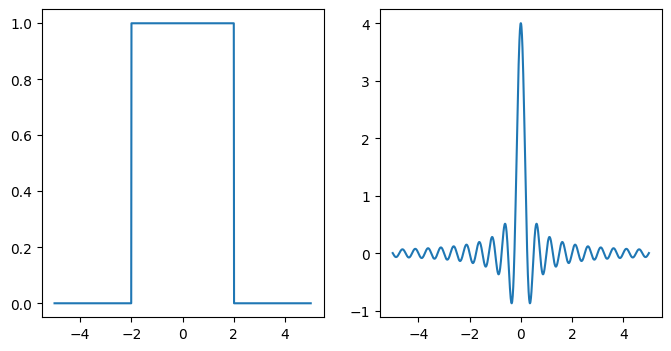

In [5]:
# Fourier Transform of square wave
if __name__ == "__main__":
    T = 2
    x = np.linspace(-5, 5, 1000)
    pulse = square_wave(x, start=-T, end=T)
    freq_range = np.linspace(-5, 5, 1000)
    ft_pulse = ctft(x, pulse, freq_range)

    x = [x, freq_range]
    y = [pulse, ft_pulse]
    plot_plots(x, y)

#### Fourier series of discrete time periodic signals

In [6]:
if __name__ == "__main__":
    x = np.array([1,1,0,0])
    X = np.zeros(len(x), dtype=complex)
    for i in range(len(X)):
        for j in range(len(x)):
            X[i] += x[j] * np.exp(-2j * np.pi * i * j/len(x))
        X[i] /= len(x)
    
    for i in range(len(X)):
        print(f"X[{i}] = {X[i]:.2f}")

X[0] = 0.50+0.00j
X[1] = 0.25-0.25j
X[2] = 0.00-0.00j
X[3] = 0.25+0.25j


#### Fourier spectrum and phase

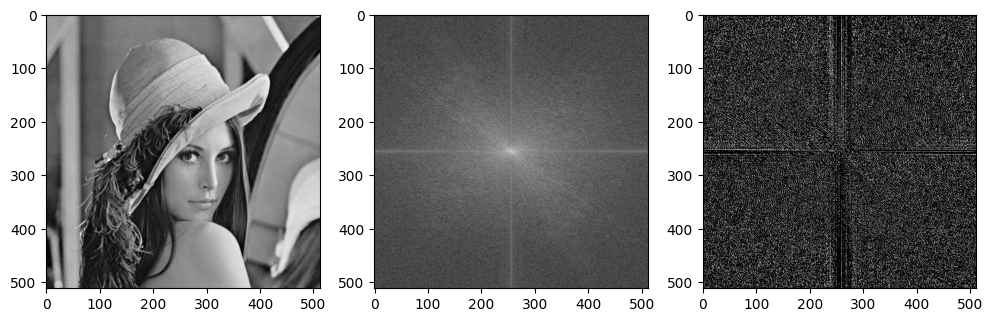

In [21]:
if __name__ == "__main__":
    image_path = './Input/Image/Lenna.png'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    magnitude_spectrum, phase_spectrum = find_magnitude_phase(img)

    imgs = [img, np.log(magnitude_spectrum+1), phase_spectrum]
    plot_images(imgs)

#### apply Ideal low pass filters & Butterworth lowpass filter

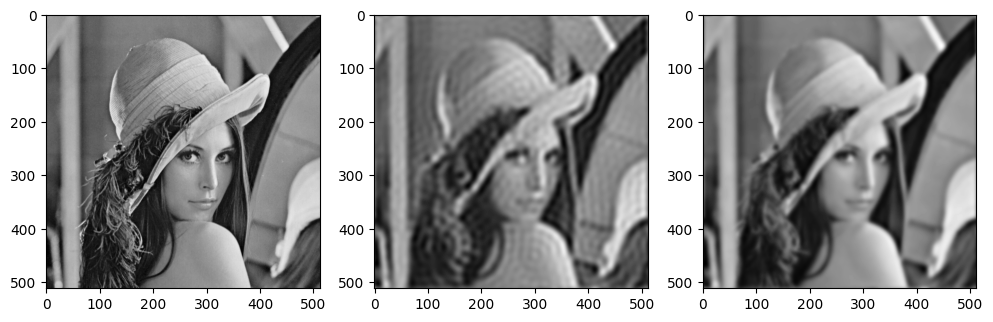

In [22]:
if __name__ == "__main__":
    image_path = './Input/Image/Lenna.png'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    cutoff = 30 # cutoff frequency
    order = 2   # Butterworth filter order

    ideal_lowpass_mask = create_ideal_lowpass_mask(img.shape, cutoff)
    butterworth_lowpass_mask = create_butterworth_lowpass_mask(img.shape, cutoff, order)

    ideal_lowpass_filtered_img = apply_dft_filter(img, ideal_lowpass_mask)
    butterworth_lowpass_filtered_img = apply_dft_filter(img, butterworth_lowpass_mask)

    imgs = [img, ideal_lowpass_filtered_img, butterworth_lowpass_filtered_img]
    plot_images(imgs)


## Image Processing

##### Low Pass Filter

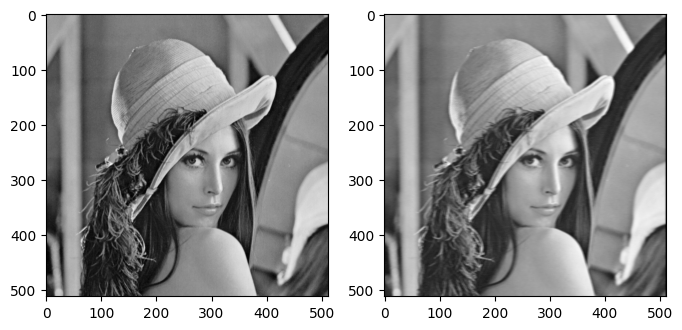

In [87]:
# Low Pass Filter
if __name__ == "__main__":
    image_path = './Input/Image/Lenna.png'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    low_pass_kernel = np.array([[0.2,0.2,0.2,0.2,0.2]])
    horizontal_sobel_kernel = np.array([[-1,0,1],
                                        [-2,0,2],
                                        [-1,0,1]])
    low_pass_filtered_img = apply_conv_filter(img, low_pass_kernel)
    imgs = [img, low_pass_filtered_img]
    plot_images(imgs)


#### extract patch

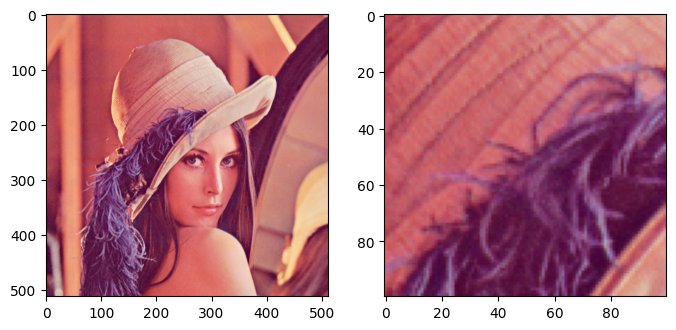

In [43]:
if __name__ == "__main__":
    image_path = './Input/Image/Lenna.png'
    img = cv2.imread(image_path)
    patch = extract_patch(img, x=150, y=150, width=100, height=100)
    imgs = [img, patch]
    plot_images(imgs, size=4, cmap='rgb')

#### Contrast function using Cube Root.

(512, 512, 3)
(512, 512, 3)


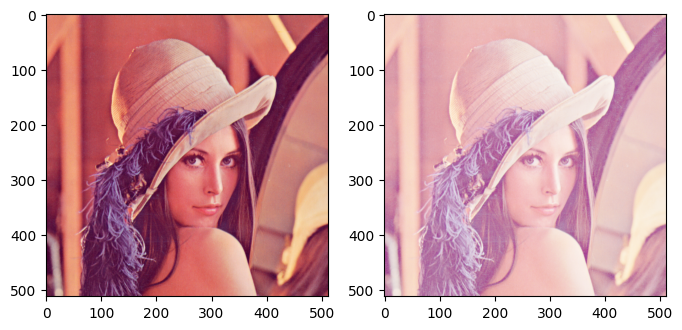

In [44]:
if __name__ == "__main__":
    image_path = './Input/Image/Lenna.png'
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    cubic_root_img = cubic_root_transformation(img)
    print(img.shape)
    print(cubic_root_img.shape)

    imgs = [img, cubic_root_img]
    plot_images(imgs, size=4, cmap='rgb')

#### Histogram equalization

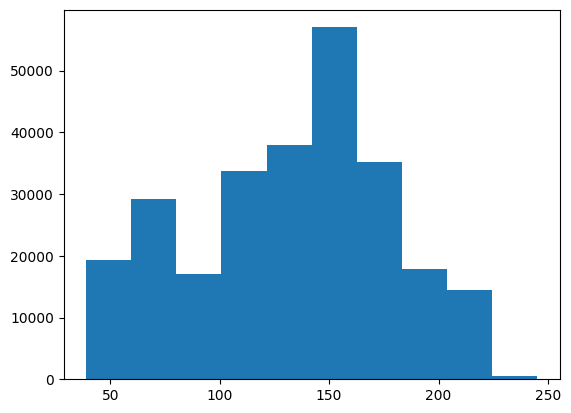

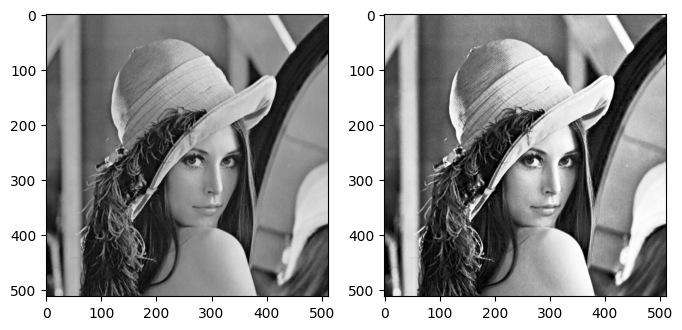

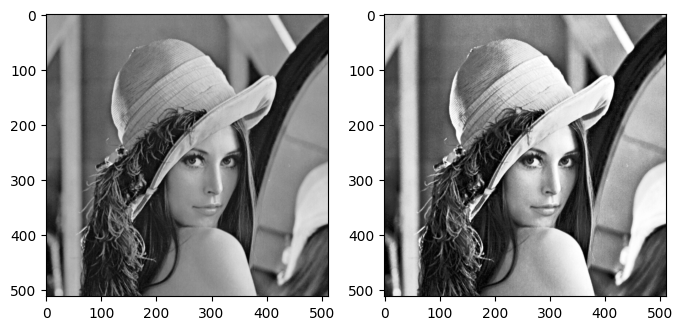

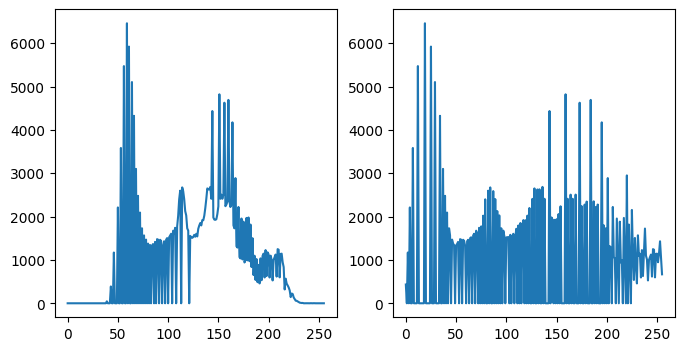

Error: 29789610


In [72]:
if __name__ == "__main__":
    image_path = './Input/Image/Lenna.png'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # made function
    equalized_img = histogram_equalization(img)

    plt.hist(img.flatten())
    plt.show()

    imgs = [img, equalized_img]
    plot_images(imgs)

    # lib function
    img, hist, equalized_img2, equalized_hist2 = histogram_equalization_lib(img)

    imgs = [img, equalized_img2]
    plot_images(imgs)
    plots = [hist, equalized_hist2]
    plot_plots(plots)
    print("Error: %d" %sum(equalized_img.flatten() - equalized_img2.flatten()))

#### Sobel filter

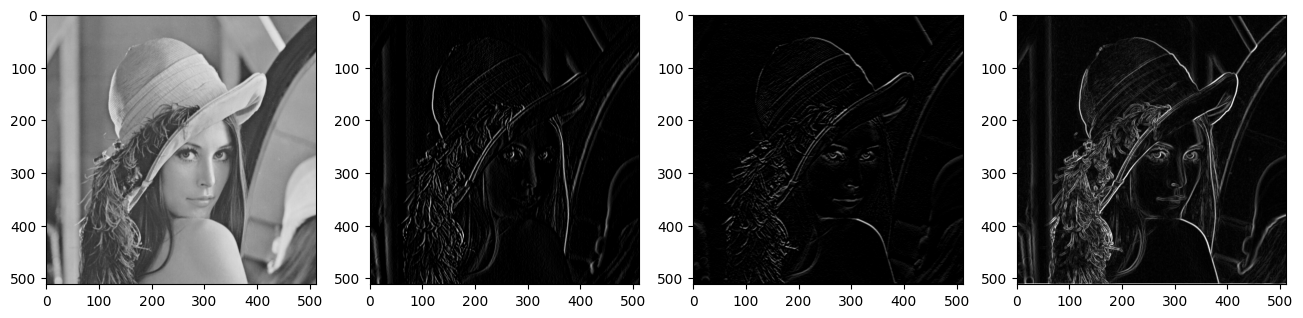

In [94]:
if __name__ == "__main__":
    image_path = './Input/Image/Lenna.png'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    gx, gy = create_sobel_kernel([3,3])
    sobel_gx_img = apply_conv_filter(img, gx)
    sobel_gy_img = apply_conv_filter(img, gy)
    sobel_combined_img = np.sqrt(sobel_gx_img**2 + sobel_gy_img**2)

    imgs = [img, sobel_gx_img, sobel_gy_img, sobel_combined_img]
    plot_images(imgs, size=4, cmap='rgb')

#### Laplacian of Gaussian

1
1


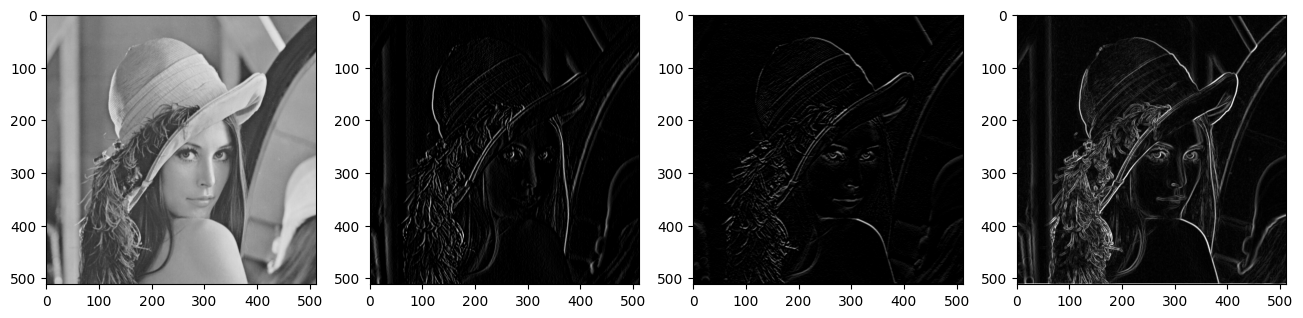

In [93]:
if __name__ == "__main__":
    image_path = './Input/Image/Lenna.png'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    gx, gy = create_sobel_kernel([3,3])
    print(gx.shape[0]//2)
    print(gx.shape[1]//2)
    sobel_gx_img = apply_conv_filter(img, gx)
    sobel_gy_img = apply_conv_filter(img, gy)
    sobel_combined_img = np.sqrt(sobel_gx_img**2 + sobel_gy_img**2)

    imgs = [img, sobel_gx_img, sobel_gy_img, sobel_combined_img]
    plot_images(imgs, size=4, cmap='rgb')

#### derivative of Gaussian

#### TBD